# ISSUE FIXED IN #403/#404

In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# sbi
import sbi.utils as utils
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi.utils import pairplot, conditional_pairplot, conditional_corrcoeff, eval_conditional_density

In [18]:
# setting random seed
np.random.seed(333)

def simulator_placeholder(params):
    """Noisy Identity.
    Takes a vector of 3 parameters and adds noise."""
    S = np.array([[88.5333, -33.6, -5.33333], 
         [-33.6, 15.4424, 2.66667], 
         [-5.33333, 2.66667, 0.484848]])
    
    return np.random.multivariate_normal(np.array(params),S) + np.array(params)*np.random.random(3)*10

In [3]:
# mock observation
x_o = np.array([ 10., -3., 1e-5])

In [4]:
# pre-simulating data
prior_min = [0.1, -10., -1e-4]
prior_max = [100., 10., 1e-4]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

prior_sample = prior.sample((2000,))

thetas = []
outputs = []
for params in prior_sample:
    result = simulator_placeholder(params)
    outputs.append(result)
    thetas.append(params)

thetas = torch.stack(thetas, dim=0)
outputs = np.array(outputs)

In [5]:
# setting up sbi
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))
simulator, prior = prepare_for_sbi(simulator_placeholder, prior)

density_estimator_build_fun = posterior_nn(model='mdn') # Here you could change your model e.g. to 'maf' or 'nsf' 

In [ ]:
inference = SNPE(prior, density_estimator=density_estimator_build_fun, 
                 show_progress_bars=True, num_workers=2)

density_estimator = inference.append_simulations(torch.as_tensor(thetas, dtype=torch.float32), \
                               torch.as_tensor(outputs, dtype=torch.float32)).train()

posterior = inference.build_posterior(density_estimator)  # MCMC kwargs go here.

/home/jnsbck/Applications/anaconda3/envs/sbi_env/lib/python3.7/site-packages/sbi/inference/base.py:120: UserWarning: You passed some keyword arguments that will not be used. Specifically, the unused arguments are: ['num_workers']. These arguments might have been supported in sbi versions <0.14.0. Since 0.14.0, the API was changed. Please consult the corresponding pull request on github: https://github.com/mackelab/sbi/pull/378 and tutorials: https://www.mackelab.org/sbi/tutorial/02_flexible_interface/ for further information.
  f"You passed some keyword arguments that will not be used. "
/home/jnsbck/Applications/anaconda3/envs/sbi_env/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachab

In [ ]:
#torch.save(posterior, "./models/model_name")
#posterior = torch.load("./models/model_name")

In [ ]:
fig, axes = utils.pairplot(samples,
                           limits=list(zip(prior_min,prior_max)),
                           ticks=list(zip(prior_min,prior_max)),
                           points=x_o,
                           fig_size=(5,5),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [ ]:
posterior.set_default_x(x_o)

corr_matrix_marginal = np.corrcoef(samples.T)
fig, ax = plt.subplots(1,1, figsize=(4, 4))
im = plt.imshow(corr_matrix_marginal, clim=[-1, 1], cmap='PiYG')
_ = fig.colorbar(im)

In [ ]:
posterior.set_default_x(x_o)
condition = posterior.sample((1,))

In [ ]:
_ = conditional_pairplot(density=posterior,
                         condition=condition,
                         limits=list(zip(prior_min,prior_max)),
                         ticks=list(zip(prior_min,prior_max)),
                         fig_size=(5,5),
                         points_offdiag={'markersize': 6},
                         points_colors='r',)

In [ ]:
# compute conditional correlations
cond_coeff_mat = conditional_corrcoeff(
    density=posterior,
    condition=condition,
    limits=torch.tensor(list(zip(prior_min,prior_max))))
fig, ax = plt.subplots(1,1, figsize=(4,4))
im = plt.imshow(cond_coeff_mat, clim=[-1, 1], cmap='PiYG')
_ = fig.colorbar(im)

# without clim=[-1,1]
cond_coeff_mat = conditional_corrcoeff(
    density=posterior,
    condition=condition,
    limits=torch.tensor(list(zip(prior_min,prior_max))))
fig, ax = plt.subplots(1,1, figsize=(4,4))
im = plt.imshow(cond_coeff_mat, cmap='PiYG')
_ = fig.colorbar(im)
plt.show()

In [ ]:
print(cond_coeff_mat)

In [92]:
# SBI Version: 0.14.2

In [19]:
posterior = torch.load("../trained_posteriors/mdn_posterior_20200403_sample_4")

In [20]:
# summary stats of observation
x_o = torch.Tensor([[-5.75389341e+01,  6.03319947e+01,  4.80000000e-01,
        -1.30100697e+01, -5.30087241e+01,  5.46803959e+01,
         4.80000000e-01, -1.58292018e+01,  6.00000000e+01,
        -6.26428467e-02,  4.72888401e-01, -2.88095614e+00,
         2.07261305e-02, -2.04364018e+00,  1.56548602e+00,
         8.18181818e-01, -9.00351155e+01, -5.52679806e+01,
         1.56934474e+02,  2.61451161e+00]])

# parameter sample with simulation output close to observation
theta_o = torch.Tensor([ 9.3269e+00,  9.2351e+00,  2.7299e-01,  1.8406e-01,  5.2918e+02,
        -7.0732e+01, -8.9854e+01,  5.4661e-01])

# prior (no leakage issues)
prior_min = [.5, 1e-4, 1e-4, 1e-4, 50, -90, -100, 0.1]
prior_max = [80., 30, 0.6, 0.6, 3000, -40, -35, 3]

samples = posterior.sample((20000,), x=x_o)

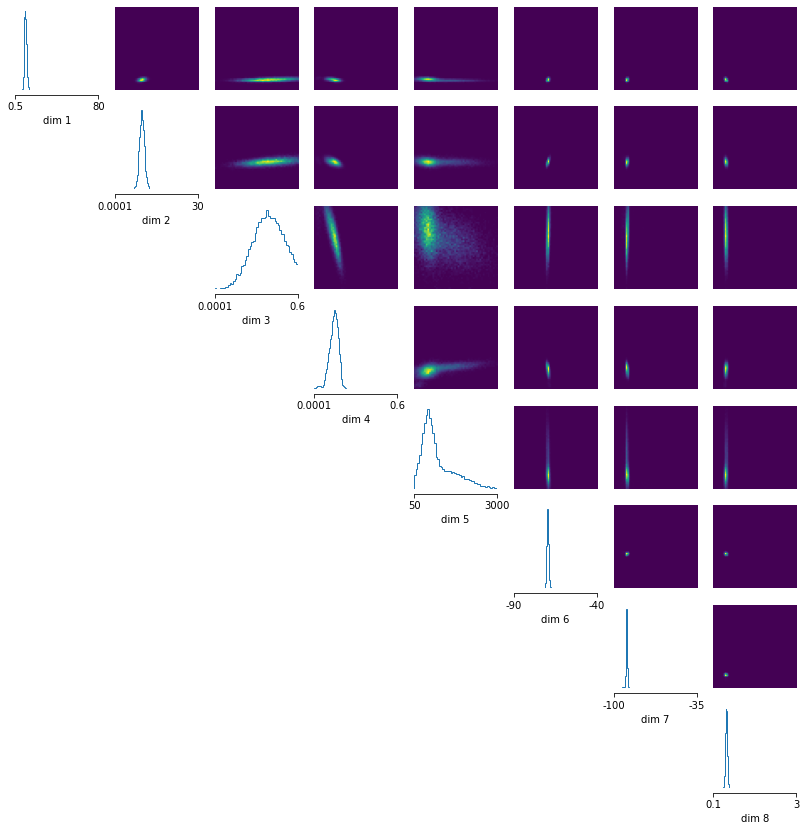

In [21]:
fig, axes = utils.pairplot(samples,
                           limits=list(zip(prior_min,prior_max)),
                           ticks=list(zip(prior_min,prior_max)),
                           #points=theta_o,
                           fig_size=(14,14),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [22]:
posterior.set_default_x(x_o)
condition = posterior.sample([1,])

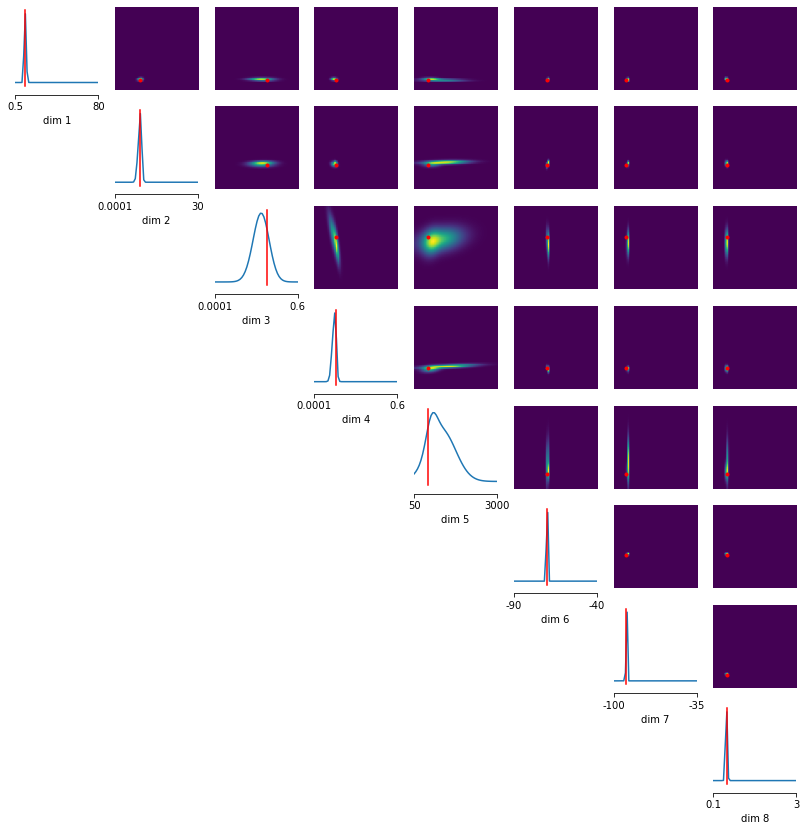

In [23]:
_ = conditional_pairplot(density=posterior,
                         condition=condition,
                         points=condition,
                         limits=list(zip(prior_min,prior_max)),
                         ticks=list(zip(prior_min,prior_max)),
                         fig_size=(14,14),
                         points_offdiag={'markersize': 6},
                         points_colors='r',)

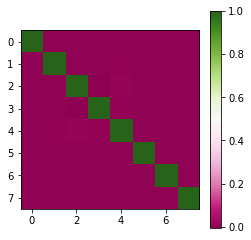

In [24]:
# without clim=[-1,1]
cond_coeff_mat = conditional_corrcoeff(density=posterior,
                                       condition=condition,
                                       limits=torch.tensor(list(zip(prior_min,prior_max))))

fig, ax = plt.subplots(1,1, figsize=(4,4))
im = plt.imshow(cond_coeff_mat, cmap='PiYG')
_ = fig.colorbar(im)
plt.show()

In [25]:
print(torch.min(cond_coeff_mat))
print(cond_coeff_mat < -1)

tensor(-0.0073)
tensor([[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]])
